In [ ]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure

In [ ]:
def generate_blobs(length = 64, blob_size_fraction = 0.1, big_scale = 4,
                   n_dim = 2,
                   volume_fraction = 0.2, seed = None):
  rs = np.random.default_rng(seed)
  shape = tuple([length] * n_dim)
  mask = np.zeros(shape)
  mask2 = np.zeros(shape)
  n_pts = max(int(1. / blob_size_fraction) ** n_dim, 1)
  points = (length * rs.random((n_dim, n_pts))).astype(int)
  mask[tuple(indices for indices in points[:,:-1])] = 1
  mask2[tuple(indices for indices in points[:,-1:])] = 1

  mask = gaussian(mask, sigma=0.25 * length * blob_size_fraction,
                  preserve_range=False)
  mask2 = gaussian(mask2, sigma = 0.25 * big_scale * length * blob_size_fraction,
                  preserve_range = False)
  mask3 = (mask/(mask.sum())+mask2/(mask2.sum()))

  threshold = np.percentile(mask3, 100 * (1 - volume_fraction))
  return np.logical_not(mask3 < threshold)

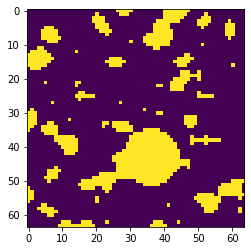

In [ ]:
x = generate_blobs(length=64, blob_size_fraction = 0.1, big_scale = 2)
plt.imshow(x)

In [ ]:
N = 4000 # number of images
size = 64

labels = np.random.randint(2, size = N) #create binary labels, 0 = pathological, 1 = healthy
imgs = np.zeros((size, size, N))

length = 64
blob_size_fraction = 0.1
big_scale = 4
n_dim = 2
volume_fraction = 0.3

for i in range(N):
  if labels[i] == 0:
    x = generate_blobs(length = length,
                       blob_size_fraction=blob_size_fraction,
                       big_scale = big_scale,
                       n_dim = n_dim,
                       volume_fraction = volume_fraction)
  elif labels[i] == 1:
    x = generate_blobs(length = length,
                       blob_size_fraction=blob_size_fraction,
                       big_scale = 1,
                       n_dim = n_dim,
                       volume_fraction = volume_fraction)
  
  imgs[:,:,i] = x

[1 1 1 0 0 0 1 1 1 1]


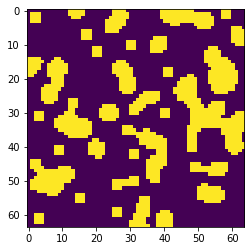

In [ ]:
plt.imshow(imgs[:,:,1])

print(labels[:10])

(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2]), array([12, 13, 14, 15, 16, 12, 13, 14, 15, 16, 13, 14, 15]))


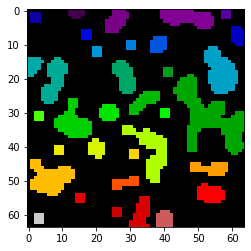

In [ ]:
seg = measure.label(imgs[:,:,1], background = 0)
plt.imshow(seg, cmap="nipy_spectral")
print(np.where(seg==1))

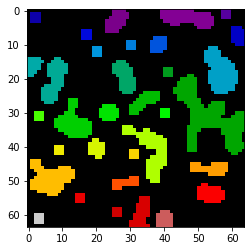

In [ ]:
seg[seg == 1] = 0
plt.imshow(seg, cmap="nipy_spectral")

In [ ]:
#prepare data for training
from sklearn.model_selection import train_test_split
X = np.expand_dims(imgs, -1)
X = np.transpose(X, (2,1,0,3))
y=labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X.shape

(4000, 64, 64, 1)

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Model / data parameters
num_classes = 2
input_shape = (size, size, 1)

# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

# Train model:
batch_size = 64
epochs = 20

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 features (Flatten)          (None, 12544)             0         
                                                                 
 dropout_4 (Dropout)         (None, 12544)            

In [ ]:
# Validate model
from sklearn.metrics import classification_report

label_names = ['Pathological', 'Healthy']

score = model.evaluate(X_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

y_test_pred_DL_full = np.argmax(model.predict(X_test),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test, y_test_pred_DL_full, target_names=label_names))

Test loss: 0.3411058783531189
Test accuracy: 0.8674242496490479
              precision    recall  f1-score   support

Pathological       0.99      0.74      0.85       666
     Healthy       0.79      0.99      0.88       654

    accuracy                           0.87      1320
   macro avg       0.89      0.87      0.87      1320
weighted avg       0.89      0.87      0.87      1320



In [ ]:
#save model if needed
model.save("model_10")

In [ ]:
#load model if needed
model = tf.keras.models.load_model("model_10")
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 features (Flatten)          (None, 12544)             0         
                                                                 
 dropout_3 (Dropout)         (None, 12544)            

In [ ]:
#Code for Occlusion Mapping, slightly modified from
#https://gist.github.com/RaphaelMeudec/7985b0c5eb720a29021d52b0a0be549a

import numpy as np
import tensorflow as tf

grey_value = 1 #1 = white, 0 = black
# Create function to apply a grey patch on an image
def apply_grey_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = grey_value

    return patched_image

PATCH_SIZE = 8


img = X_test[np.where(y_test == 0)[0][0]]
img_class = y_test[np.where(y_test == 0)[0][0]]

img = X_test[4]
img_class = y_test[4]
np.where(y_test == 0)

(array([   2,    4,    8,   10,   13,   16,   21,   29,   32,   34,   37,
          38,   43,   46,   48,   49,   51,   56,   57,   60,   62,   64,
          65,   66,   68,   70,   77,   78,   79,   81,   82,   83,   85,
          86,   93,   94,   95,   96,   97,   98,  102,  103,  104,  106,
         107,  112,  113,  114,  117,  118,  119,  124,  129,  133,  134,
         136,  139,  140,  141,  147,  148,  150,  154,  155,  157,  160,
         163,  164,  168,  169,  171,  172,  173,  175,  176,  177,  182,
         183,  185,  188,  189,  190,  191,  192,  197,  198,  199,  200,
         202,  203,  204,  206,  208,  209,  211,  213,  214,  215,  218,
         219,  221,  225,  227,  228,  236,  238,  243,  245,  248,  251,
         252,  256,  259,  260,  262,  264,  265,  267,  268,  269,  270,
         271,  272,  275,  276,  277,  278,  282,  284,  285,  288,  289,
         290,  291,  293,  295,  297,  298,  299,  302,  303,  304,  305,
         308,  309,  310,  311,  312, 

[0.9826177  0.01738228]


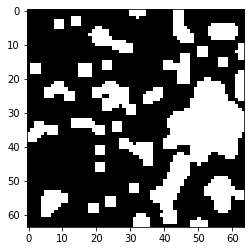

In [ ]:
plt.imshow(img.squeeze(), cmap=plt.cm.gray)
predicted_classes = model.predict(np.array([img]))
print(predicted_classes[0])

In [ ]:
#Occlusion Map occluding one "blob" at a time
#apply non-overlapping sensitivity map
sensitivity_map = np.zeros((img.shape[0], img.shape[1]))
regions, num_regions = measure.label(img, background = 0, return_num=True)

img_ex_blob = 0
lowest_confidence = 1.
# Iterate the patch over the image
for region in range(1,num_regions+1):
  patched_image = np.array(regions, copy = True)
  patched_image[patched_image == region] = 0
  patched_image[patched_image > 0] = 1
  predicted_classes = model.predict(np.array([patched_image]))[0]
  confidence = predicted_classes[img_class]

  #save occlusion image with highest difference in confidence
  if confidence < lowest_confidence:
    img_ex_blob = patched_image
    lowest_confidence = confidence

  # Save confidence for this specific patched image in map
  sensitivity_map[
      np.where(regions == region)[0],
      np.where(regions == region)[1]
  ] = confidence

sensitivity_map[sensitivity_map==0] = 0



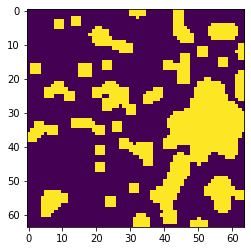

In [ ]:
plt.imshow(img_ex_blob.squeeze())

In [ ]:
#apply non-overlapping sensitivity map
PATCH_SIZE = 8
sensitivity_map = np.zeros((img.shape[0], img.shape[1]))

# Iterate the patch over the image
for top_left_x in range(0, img.shape[0], PATCH_SIZE):
    for top_left_y in range(0, img.shape[1], PATCH_SIZE):
        patched_image = apply_grey_patch(img, top_left_x, top_left_y, PATCH_SIZE)
        predicted_classes = model.predict(np.array([patched_image]))[0]
        confidence = predicted_classes[img_class]
        
        # Save confidence for this specific patched image in map
        sensitivity_map[
            top_left_y:top_left_y + PATCH_SIZE,
            top_left_x:top_left_x + PATCH_SIZE,
        ] = confidence

In [ ]:
#variation on the sensitivity map with overlapping patches
sensitivity_map = np.zeros((img.shape[0], img.shape[1]))
PATCH_SIZE = 8
step_size = 2
# Iterate the patch over the image
for top_left_x in range(0, img.shape[0] - PATCH_SIZE + 1, step_size):
    for top_left_y in range(0, img.shape[1] - PATCH_SIZE + 1, step_size):
        patched_image = apply_grey_patch(img, top_left_x, top_left_y, PATCH_SIZE)
        predicted_classes = model.predict(np.array([patched_image]))[0]
        confidence = predicted_classes[img_class]
        
        # Save confidence for this specific patched image in map
        sensitivity_map[
            top_left_y:top_left_y + PATCH_SIZE,
            top_left_x:top_left_x + PATCH_SIZE,
        ] = (sensitivity_map[
            top_left_y:top_left_y + PATCH_SIZE,
            top_left_x:top_left_x + PATCH_SIZE,] + confidence)/2

KeyboardInterrupt: ignored

In [ ]:
#create mean sensitivity map for all instances of a class
imgs = X_test[np.where(y_test == 0)]
imgs_class = 0

#apply non-overlapping sensitivity map
maps = np.zeros(imgs.shape[:3])
# Iterate the patch over the image
for img_idx in range(0, imgs.shape[0]):
  img = imgs[img_idx, :, :, :]
  sensitivity_map = np.zeros((img.shape[0], img.shape[1]))
  for top_left_x in range(0, img.shape[0], PATCH_SIZE):
      for top_left_y in range(0, img.shape[1], PATCH_SIZE):
          patched_image = apply_grey_patch(img, top_left_x, top_left_y, PATCH_SIZE)
          predicted_classes = model.predict(np.array([patched_image]))[0]
          confidence = predicted_classes[img_class]
          
          # Save confidence for this specific patched image in map
          sensitivity_map[
              top_left_y:top_left_y + PATCH_SIZE,
              top_left_x:top_left_x + PATCH_SIZE,
          ] = confidence
  maps[img_idx, :, :] = sensitivity_map     

In [ ]:
mean_map = np.mean(maps, axis = 0)
plt.imshow(mean_map,  cmap=plt.cm.Blues)
plt.colorbar()

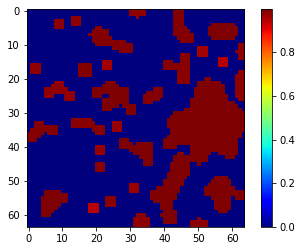

In [ ]:
#sensitivity_map = np.ones_like(sensitivity_map) - sensitivity_map
plt.imshow(sensitivity_map, cmap=plt.cm.jet)
plt.colorbar()

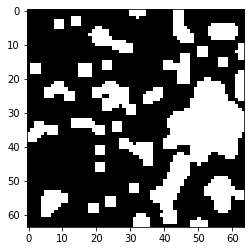

In [ ]:
plt.imshow(img.squeeze(), cmap = plt.cm.gray)

In [ ]:
fig, ax = plt.subplots(1,3)
fig.set_dpi(200)
ax[0].imshow(img.squeeze(), cmap=plt.cm.gray)
ax[1].imshow(sensitivity_map)
ax[2].imshow(img.squeeze(), cmap=plt.cm.gray)
ax[2].imshow(sensitivity_map, alpha=0.5)
fig.tight_layout()

In [ ]:
plt.imshow(img.squeeze(), cmap=plt.cm.gray)
plt.imshow(sensitivity_map, alpha=0.5, cmap=plt.cm.jet)

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_idx, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    img_array = np.array([img_array])
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.layers[last_conv_idx].output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Predicted: [0.9826177  0.01738228]


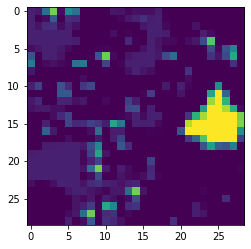

In [ ]:
last_conv_idx = -5
# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(np.array([img]))
print("Predicted:", preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img, model, last_conv_idx)

# Display heatmap
plt.imshow(heatmap)


In [ ]:
#rescale heatmap
heatmap = keras.preprocessing.image.array_to_img(np.expand_dims(heatmap, axis = -1))
heatmap = heatmap.resize((img.shape[0], img.shape[1]))
heatmap = keras.preprocessing.image.img_to_array(heatmap)
heatmap.shape

(64, 64, 1)

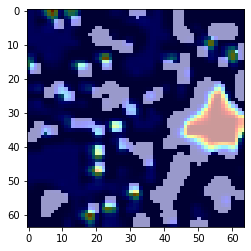

In [ ]:
plt.imshow(img.squeeze(), cmap=plt.cm.gray)
plt.imshow(heatmap.squeeze(), cmap=plt.cm.jet, alpha = 0.4)

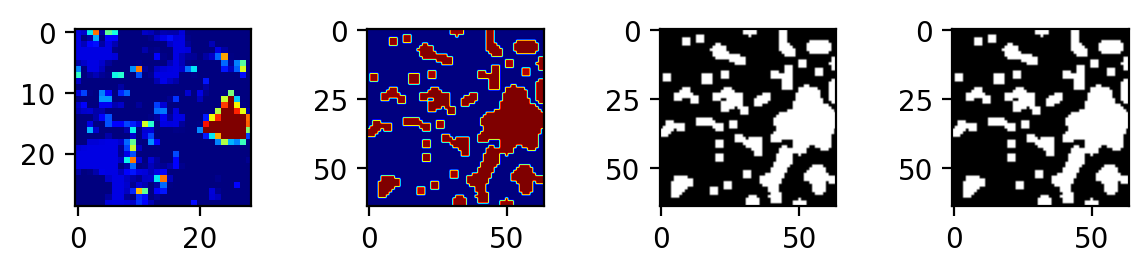

In [ ]:
fig, ax = plt.subplots(1,4)
fig.set_dpi(200)
fig.tight_layout()
ax[0].imshow(heatmap.squeeze(), cmap = plt.cm.jet)
ax[1].imshow(sensitivity_map, cmap = plt.cm.jet)
ax[2].imshow(img.squeeze(), cmap = plt.cm.gray)
ax[3].imshow(img_ex_blob.squeeze(), cmap = plt.cm.gray)
